### [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html)

<img src="px/grid_search_cross_validation.png" width="70%" />

- Learning the parameters of a prediction function and testing it on the same data is a **methodological mistake**: a model would just repeat the labels of the samples that it has just seen - but fail to predict anything useful on yet-unseen data. This is called **overfitting**. 

- When performing a (supervised) machine learning experiment, reserve part of the available data as a *test set* (X_test, y_test). The best parameters can be determined by grid search techniques.

- Use the `[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)` helper function to quickly split a dataset into training & test subsets:

In [70]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X, y = datasets.load_iris(return_X_y=True)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print(clf.score(X_test, y_test))

(150, 4) (150,)
(90, 4) (90,)
(60, 4) (60,)
0.9666666666666667


- There is still a risk of *overfitting* on the test set because the parameters can be tweaked until the estimator performs optimally. Knowledge about the test set can “leak” into the model. 

- Yet another part of the dataset can be reserved **validation** to avoid this problem. Training proceeds on the training set, preliminary evaluation is done on the validation set. When the experiment seems to be successful, final evaluation can be done on the test set.

- Partitioning datasets like this *drastically reduce the number of samples*  available for learning, so **cross-validation** ("CV") solves this problem. A test set is still reserved for final evaluation, but the validation set is no longer needed. The basic approach (k-fold CV) splits the training data into k subsets. For each of the k “folds”:

    - Train using $k-1$ folds as training data.
    - Validate the result on the remainder (use it as test set to compute a performance measure.)


- The performance measure is the average of the values computed in the loop. It can be computationally expensive but doesn't waste data - which is a major advantage in problems such as inverse inference where the #samples is very small.

### Metrics

- The simplest way to do CV is to call [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) on the estimator object & dataset.

- `cv` determines the number of "folds". Cross_val_score uses [Kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) or [Stratified Kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) if `cv` is an integer.

In [71]:
# split, fit, cv with 5-fold scoring
from sklearn.model_selection import cross_val_score
clf    = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
print("scores:\t", scores)
print("accuracy:\t %0.2f" % (scores.mean()))
print("st dev: \t  %0.2f" % (scores.std()))

scores:	 [0.96666667 1.         0.96666667 0.96666667 1.        ]
accuracy:	 0.98
st dev: 	  0.02


- Use the `score` parameter to specify the scoring method. Options are available in the [Scikit's User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

- In this case (using the Iris dataset), the *accuracy* (default) and *F1-score* metrics are nearly equal. This is partially due to the Iris samples being balanced across target classes.

In [72]:
from sklearn import metrics
print(cross_val_score(clf, X, y, cv=5, scoring='f1_macro'))

[0.96658312 1.         0.96658312 0.96658312 1.        ]


- Other CV methods are available by passing an *iterator*, either off-the-shelf or custom.

In [73]:
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
print(cross_val_score(clf, X, y, cv=cv))

[0.97777778 0.97777778 1.         0.95555556 1.        ]


In [74]:
def custom_cv_2folds(X):
    n = X.shape[0]
    i = 1
    while i <= 2:
        idx = np.arange(n * (i - 1) / 2, n * i / 2, dtype=int)
        yield idx, idx
        i += 1
print(cross_val_score(clf, X, y, cv=custom_cv_2folds(X)))

[1.         0.97333333]


### [cross_validate (vs cross_val_score)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate)

- *cross_validate* allows using *multiple metrics*. It returns both test scores and timing values in a dict.

- For single metrics (where `scoring` is a string, callable or None), it returns these keys: ['test_score', 'fit_time', 'score_time'].

- For multiple metrics, it returns these keys: ['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']

- `return_train_score=False` by default to save computation time. Set it to True to return training set scores too.

- Use `return_estimator=True` to retain the estimator trained on each fit.

- Multiple metrics can be specified as a list, tuple or set of predefined scorer names.

In [75]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

scoring = ['precision_macro', 'recall_macro']
clf     = svm.SVC(kernel='linear', C=1, random_state=0)
scores  = cross_validate(clf, X, y, scoring=scoring)

print(sorted(scores.keys()))
print(scores['test_recall_macro'])

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
[0.96666667 1.         0.96666667 0.96666667 1.        ]


In [76]:
from sklearn.metrics import make_scorer
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, X, y, scoring=scoring, cv=5, 
                        return_train_score=True)

print(sorted(scores.keys()))
print(scores['train_rec_macro'])

['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro', 'train_prec_macro', 'train_rec_macro']
[0.975      0.975      0.99166667 0.98333333 0.98333333]


### [cross_val_predict (CVP)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict)

- Similar to [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) but returns a prediction for each element in a test set.

- CVP can only be used with CV strategies that assign *all elements to a test set exactly once.*

- CVP is appropriate if you are viewing predictions *from different models*, or are using predictions from one estimator to train another. (ie "model blending" i n ensembles.)

### [Example: ROC classifier metrics with CV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py)

- ROC curves display **true positive rate (TPR)** on the Y axis, and **false positive rate (FPR)** on the X axis. 

- The *top left corner* is the “ideal” point: FPR = 0, and TPR = 1. It means that *a larger area under the curve (AUC) is usually better*.

- The “steepness” of ROC curves is important. The goal is to maximize TPR while minimizing FPR.

- This example shows the ROC curve of different K-fold CV iterations. We can calculate the *mean area* under curve, and see the *variance* from different subsets. It shows how the classifier output is affected by changes in training data, and how different the splits generated by K-fold CV are from one another.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

In [78]:
iris = datasets.load_iris()
X,y = iris.data, iris.target
X,y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 
                                200*n_features)]

cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', 
                     probability=True,
                     random_state=random_state)

tprs,aucs,mean_fpr = [],[],np.linspace(0, 1, 100)

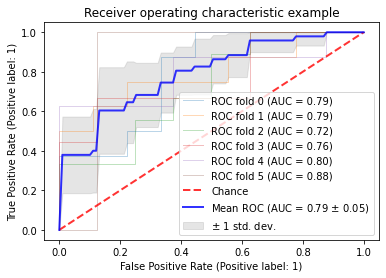

In [79]:
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr    = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
     
    tprs.append(interp_tpr); aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr     = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc     = auc(mean_fpr, mean_tpr)
std_auc      = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr    = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr+std_tpr, 1)
tprs_lower = np.maximum(mean_tpr-std_tpr, 0)

ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

### [Example: recursive Feature Elimination with CV](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py)

In [80]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

In [81]:
X, y = make_classification(n_samples=1000, 
                           n_features=25, 
                           n_informative=3,
                           n_redundant=2, 
                           n_repeated=0, 
                           n_classes=8,
                           n_clusters_per_class=1, 
                           random_state=0)

min_features = 1

rfecv = RFECV(estimator=SVC(kernel="linear"), 
              step=1, 
              cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features).fit(X, y)

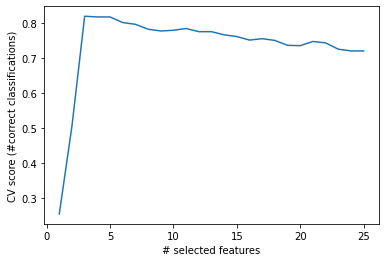

In [82]:
plt.figure()
plt.xlabel("# selected features")
plt.ylabel("CV score (#correct classifications)")
plt.plot(range(min_features,
               len(rfecv.grid_scores_)+min_features),
         rfecv.grid_scores_)

### [Example: Parameter Estimation with CV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)

In [83]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [84]:
digits = datasets.load_digits()

n_samples = len(digits.images)
X,y = digits.images.reshape((n_samples, -1)), digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

tuned_parameters = [{'kernel': ['rbf'], 
                     'gamma':  [1e-3, 1e-4],
                     'C':      [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 
                     'C':      [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

In [85]:
for score in scores:
    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score).fit(X_train, y_train)

    print("Best params in devt set:", clf.best_params_)
    print("Grid scores in devt set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))

Best params in devt set: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Grid scores in devt set:
0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.028) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.974 (+/-0.012) for {'C': 1, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 10, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 100, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}

Classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support



### [Example: Text Feature Evaluation Pipeline with CV](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py)

- Using the *20 newsgroups* dataset. Adjust the #categories by giving their names to the dataset loader or None to get all 20.

In [86]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [87]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
categories = ['alt.atheism','talk.religion.misc']
#categories = None
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# more parameters = better exploring power but more CPU run time
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)


['alt.atheism', 'talk.religion.misc']
857 documents
2 categories


In [88]:
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:"); pprint(parameters)
t0 = time()
grid_search.fit(data.data, data.target)
print("done in %0.3fs" % (time() - t0))
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
done in 12.090s
Best score: 0.950
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


### [Example: Prediction Plots with CV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py)

- Diabetes toy dataset; linear regression model.

In [89]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

In [90]:
lr        = linear_model.LinearRegression()
X, y      = datasets.load_diabetes(return_X_y=True)
predicted = cross_val_predict(lr, X, y, cv=10)

Text(0, 0.5, 'Predicted')

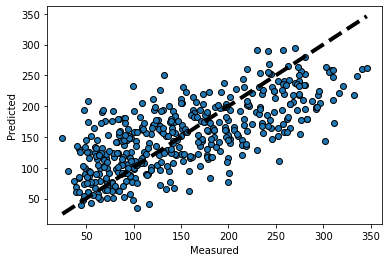

In [91]:
fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

### [Example: Nested vs Non-Nested CV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py)

- Iris toy dataset.
- Model selection without nested CV *uses the same data*, so information may “leak” into the model and overfit the data. The magnitude of the problem is mostly dependent on dataset size & model stability.

- Nested CV effectively uses a series of *train/validation/test set splits*. In the **inner loop** (here: `GridSearchCV`), the score is found by fitting a model to each training set, then maximized in selecting (hyper)parameters over the validation set. In the **outer loop** (here: `cross_val_score`), generalization error is found by averaging test set scores over several dataset splits.

- The example uses a **support vector classifier (SVC)** with a non-linear kernel to build the model with optimized hyperparameters by grid search. We compare the performance of non-nested and nested CV strategies by taking the difference between their scores.

In [92]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

In [93]:
NUM_TRIALS = 30

iris   = load_iris()
X,y    = iris.data, iris.target
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}

svm           = SVC(kernel="rbf")
scores        = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):

    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv).fit(X,y)
    scores[i] = clf.best_score_

    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = scores - nested_scores
print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

Average difference of 0.007581 with std. dev. of 0.007833.


Text(0, 0.5, 'score difference')

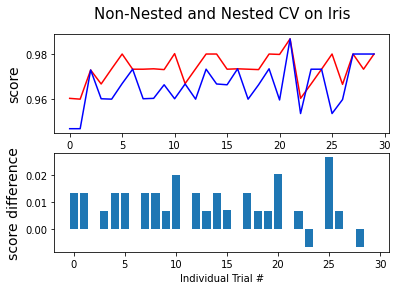

In [94]:
plt.subplot(211)
scores_line = plt.plot(scores,        color='r')
nested_line = plt.plot(nested_scores, color='b')

plt.ylabel("score", fontsize="14")
#plt.legend([scores_line, nested_line], ["CV", "Nested CV"], bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested CV on Iris", x=.5, y=1.1, fontsize="15")

plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
#plt.legend([difference_plot],["Non-Nested CV - Nested CV Score"],bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")


### [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

- **KFold** divides samples into $k$ groups, called folds of equal sizes (if possible). The prediction is learned using $k-1$ folds. The remaining fold is used for test.

In [95]:
import numpy as np
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d", "e", "f", "g", "h"]
kf = KFold(n_splits=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[4 5 6 7] [0 1 2 3]
[0 1 2 3] [4 5 6 7]


### [Stratified KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold)

- **RepeatedKFold** repeats K-Fold n times. Use it to produce different splits in each of n repetitions.

Example of 2-fold K-Fold repeated 2 times:

In [96]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
for train, test in rkf.split(X):
    print("%s %s" % (train, test))

[2 3] [0 1]
[0 1] [2 3]
[0 2] [1 3]
[1 3] [0 2]


### [Leave One Out (LOO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut)

- Each learning set is created by taking all the samples except one (the test set). For $n$ samples we have $n$ training sets and $n$ different test sets. This  method does not waste data as only one sample is removed from the training set.

- When compared with Kfold cross validation, one builds $n$ models from $n$ samples instead of $k$ models, where $n>k$. Each is trained on $n-1$ samples, not $(k-1)n/k$.

- LOO is more computationally expensive & often returns high test error estimate variance. Since $n-1$ of $n$ samples are used to build each model, models constructed from folds are virtually identical to each other and to the model built from the entire training set.

- If the learning curve is steep for the training size in question, then 5- or 10- fold cross validation can overestimate the generalization error.

- 5- or 10- fold cross validation is preferred to LOO.

In [97]:
from sklearn.model_selection import LeaveOneOut
X = [1, 2, 3, 4]
for train, test in LeaveOneOut().split(X):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


### [Leave P Out (LPO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html#sklearn.model_selection.LeavePOut)

- It creates all possible training & test sets by removing $p$ samples from the complete set. This produces ${n \choose p}$ training/test pairs from $n$ samples. 

- Unlike LOO and KFold, the test sets will overlap for $p>1$.

In [98]:
from sklearn.model_selection import LeavePOut

X = np.ones(6)
for train, test in LeavePOut(p=2).split(X):
    print("%s %s" % (train, test))

[2 3 4 5] [0 1]
[1 3 4 5] [0 2]
[1 2 4 5] [0 3]
[1 2 3 5] [0 4]
[1 2 3 4] [0 5]
[0 3 4 5] [1 2]
[0 2 4 5] [1 3]
[0 2 3 5] [1 4]
[0 2 3 4] [1 5]
[0 1 4 5] [2 3]
[0 1 3 5] [2 4]
[0 1 3 4] [2 5]
[0 1 2 5] [3 4]
[0 1 2 4] [3 5]
[0 1 2 3] [4 5]


### [Shuffle & Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit)

- Generates a user-defined number of independent training / test splits. Samples are first shuffled and then split.

- You can control the randomness for reproducibility by seeding the `random_state` pseudo random number generator.

In [99]:
from sklearn.model_selection import ShuffleSplit
X = np.arange(10)
for train_index, test_index in ShuffleSplit(n_splits=5, 
                                            test_size=0.25, 
                                            random_state=0).split(X):
    print("%s %s" % (train_index, test_index))

[9 1 6 7 3 0 5] [2 8 4]
[2 9 8 0 6 7 4] [3 5 1]
[4 5 1 0 6 9 7] [2 3 8]
[2 7 5 8 0 3 4] [6 1 9]
[4 1 0 6 8 9 3] [5 2 7]


### **Class label-based stratfication**

- Some classification problems have *large class distribution imbalances* - for instance, several times more negative samples than positive samples. 

- In such cases use *stratified sampling* to ensure relative class frequencies are preserved in each train and validation fold.

### [Stratified KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

- Notice how SKF preserves class ratios in the training & test sets.

In [100]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))

skf = StratifiedKFold(n_splits=3)
kf  =           KFold(n_splits=3)

print("bincounts:\nStratified Kfold")
for train, test in skf.split(X, y):
    print('train: {} | test: {}'.format(
        np.bincount(y[train]), 
        np.bincount(y[test])))

print("Kfold")
for train, test in kf.split(X, y):
    print('train: {} | test: {}'.format(
        np.bincount(y[train]), 
        np.bincount(y[test])))

bincounts:
Stratified Kfold
train: [30  3] | test: [15  2]
train: [30  3] | test: [15  2]
train: [30  4] | test: [15  1]
Kfold
train: [28  5] | test: [17]
train: [28  5] | test: [17]
train: [34] | test: [11  5]


### [Stratified Shuffle Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit)

- Creates splits by preserving the same percentage for each target class as in the complete set.

### **Cross Validation on "Grouped" Data**

- The i.i.d. assumption is broken if the underlying generative process yields *groups of dependent samples*.

- Data groupings are domain specific, for example medical data from multiple patients with multiple samples taken per patient. In this case the *patient id* for each sample will be its group identifier.

- We want to know if a model trained on a specific set of groups generalizes well to *unseen groups*. To measure this, we need to ensure that all samples in the validation fold come from groups that are not represented in the paired training fold.

### [Group Kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold)

- Ensures the same group is not represented in both testing and training sets. 

- For example if data is obtained from different subjects with several samples per subject, and the model can learn from highly person specific features it could fail to generalize to new subjects. GroupKFold makes it possible to detect this kind of overfitting situations.

In [102]:
# Each subject is in a different testing fold
# the same subject is never in both testing and training
# folds do not have exactly the same size due to the imbalance in the data.

from sklearn.model_selection import GroupKFold

X      = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
y      = ["a", "b", "b", "b", "c", "c", "c", "d", "d", "d"]
groups = [ 1,   1,   1,   2,   2,   2,   3,   3,   3,   3]

for train, test in GroupKFold(n_splits=3).split(X, y, groups=groups):
    print("%s %s" % (train, test))

[0 1 2 3 4 5] [6 7 8 9]
[0 1 2 6 7 8 9] [3 4 5]
[3 4 5 6 7 8 9] [0 1 2]


### [Leave One Group Out (LOGO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut)

- Reserves samples according to a third-party-provided array of integer groups. This group information can be used to encode *arbitrary domain-specific cross-validation folds.*

- Each training set thus contains all the samples except the ones related to a specific group.

- For example, in the cases of multiple experiments, LOGO can be used to create a cross-validation based on the different experiments.

- Another common application is to use time information: for example, groups could be the year of collection of the samples and thus allow for cross-validation against time-based splits.

In [103]:
from sklearn.model_selection import LeaveOneGroupOut

X      = [1, 5, 10, 50, 60, 70, 80]
y      = [0, 1,  1,  2,  2,  2,  2]
groups = [1, 1,  2,  2,  3,  3,  3]

for train, test in LeaveOneGroupOut().split(X, y, groups=groups):
    print("%s %s" % (train, test))

[2 3 4 5 6] [0 1]
[0 1 4 5 6] [2 3]
[0 1 2 3] [4 5 6]


### [Leave P Groups Out (LPGO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePGroupsOut.html#sklearn.model_selection.LeavePGroupsOut)

- Similar as LOGO, but removes samples from $P$ groups for each training/test set.

In [104]:
from sklearn.model_selection import LeavePGroupsOut

X = np.arange(6)
y = [1, 1, 1, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3]

for train, test in LeavePGroupsOut(n_groups=2).split(X, y, groups=groups):
    print("%s %s" % (train, test))

[4 5] [0 1 2 3]
[2 3] [0 1 4 5]
[0 1] [2 3 4 5]


### [Group Shuffle Split (GSS)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html#sklearn.model_selection.GroupShuffleSplit)

- Acts as a combination of ShuffleSplit and LPGO. It generates a sequence of random partitions in which a subset of groups are held out for each split.

- This method is useful when the behavior of LPGO is desired, but the #groups is very large (generating all possible partitions with groups withheld would be prohibitively expensive). GSS provides a random sample (with replacement) of the train / test splits generated by LPGO.

In [105]:
from sklearn.model_selection import GroupShuffleSplit

X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 0.001]
y = ["a", "b", "b", "b", "c", "c", "c", "a"]
groups = [1, 1, 2, 2, 3, 3, 4, 4]

gss = GroupShuffleSplit(n_splits=4, test_size=0.5, random_state=0)
for train, test in gss.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[0 1 2 3] [4 5 6 7]
[2 3 6 7] [0 1 4 5]
[2 3 4 5] [0 1 6 7]
[4 5 6 7] [0 1 2 3]


### [Predefined Split Methods](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html#sklearn.model_selection.PredefinedSplit)

- For some datasets, a predefined split of the data already exists. For example, when using a validation set, set the test_fold to 0 for all samples that are part of the validation set, and to -1 for all other samples.

### [Using CV Iterators as Dataset Splitters]()

- Note the convenience function `train_test_split` is a wrapper around `ShuffleSplit` - it only allows for stratified splitting (using class labels) and cannot account for groups.

- To perform the split, use the indices for the train and test subsets yielded by the generator output by the `split` method of the cross-validation splitter.

In [106]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit as GSS

X      = np.array([0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 0.001])
y      = np.array(["a", "b", "b", "b", "c", "c", "c", "a"])
groups = np.array([ 1,   1,   2,   2,   3,   3,   4,   4])

train_indx, test_indx = next(
    GSS(random_state=7).split(X, y, groups)
)
X_train, X_test, y_train, y_test = \
    X[train_indx], X[test_indx], y[train_indx], y[test_indx]

print(X_train.shape, 
      X_test.shape)
print(np.unique(groups[train_indx]), 
      np.unique(groups[test_indx]))


(6,) (2,)
[1 2 4] [3]


### [Time Series Split (TSS)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)

- Time series data contains *correlation between observations that are near in time* (autocorrelation). 

- Classical CV techniques such as *KFold* and *ShuffleSplit* assume the samples are i.i.d., and would result in unreasonable correlation between training and testing instances (yielding poor estimates of generalisation error). 

- Therefore, it is important to evaluate time series data on the “future” observations *least like those that are used to train the model*.

- TSS returns the 1st $k$ folds as the training set and the $k+1$th fold as the test set. 

- Unlike classic CV methods, successive training sets are *supersets of those that come before them*. Also, it adds all surplus data to the first training partition, which is always used to train the model.

- This method is used to CV samples that are observed at fixed time intervals.

In [107]:
from sklearn.model_selection import TimeSeriesSplit as TSS

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

for train, test in TSS(n_splits=3).split(X):
    print("%s %s" % (train, test))

[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


### [Permutation Testing](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.permutation_test_score.html#sklearn.model_selection.permutation_test_score)

- `permutation_test_score` offers another way to evaluate classifier performance. It returns a *permutation-based p-value* (how likely an observed performance of the classifier would be obtained by chance). 

- The null hypothesis in this test is the classifier fails to leverage any statistical dependency between the features and the labels to make correct predictions on left out data. 

- `permutation_test_score` generates a null distribution by calculating *n_permutations* different permutations of the data. In each permutation the labels are randomly shuffled, thereby removing any dependency between the features and the labels. 

- The p-value output is the *fraction of permutations* for which the average CV score is better than the CV score using the original data. For reliable results `n_permutations` should typically be >100 and `cv` between 3-10 folds.

- A low p-value indicates the dataset contains a real dependency between features and labels - and the classifier was able to use this to obtain good results. 

- A high p-value could be due to a lack of dependency between features and labels (there is no difference in feature values between the classes) or because the classifier was not able to use the dependency in the data. In the latter case, using a more appropriate classifier that is able to utilize the structure in the data, would result in a low p-value.

- A classifier trained on a high dimensional dataset with no structure may still perform better than expected on CV, just by chance. This can happen with small datasets. `permutation_test_score` indicates whether the classifier has found a real class structure and can help in evaluating its performance.

- This test can produce low p-values even if there is only a weak structure in the data, because in the corresponding permutated datasets there is absolutely no structure. This test is therefore only able to show when the model reliably outperforms random guessing.

- `permutation_test_score` is computed using brute force and interally fits *(n_permutations+1)*n_cv* models. It is therefore only tractable with small datasets for which fitting an individual model is very fast.

### [Example: Permutation testing of Classification Performance](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html#sphx-glr-auto-examples-feature-selection-plot-permutation-test-for-classification-py)

- Plot a histogram of the permutation scores.
    - Red line: classifier score, original data - much better than that obtained with permuted data. p-value is very low. This says there is low chance of this good score being obtained by chance. It provides evidence the Iris dataset contains real dependencies between features & labels. The classifier was able to use this.

In [108]:
from sklearn.datasets import load_iris

iris = load_iris()
X,y = iris.data, iris.target

# random feature data, 2200 features, uncorrelated with iris class labels:
import numpy as np
n_uncorrelated_features = 2200
rng = np.random.RandomState(seed=0)
# Use same number of samples as in iris and 2200 features
X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))

In [109]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.model_selection import permutation_test_score as PTS

clf = SVC(kernel='linear', random_state=7)
cv  = SKF(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = PTS(
    clf, X, y, scoring="accuracy", cv=cv, n_permutations=1000)

score_rand, perm_scores_rand, pvalue_rand = PTS(
    clf, X_rand, y, scoring="accuracy", cv=cv, n_permutations=1000)

- **original data**: Below we plot a histogram of the permutation scores (the null distribution). The red line indicates the score obtained by the classifier on the original data. The score is much better than those obtained by using permuted data and the p-value is thus very low. This indicates that there is a low likelihood that this good score would be obtained by chance alone. It provides evidence that the iris dataset contains real dependency between features and labels and the classifier was able to utilize this to obtain good results.

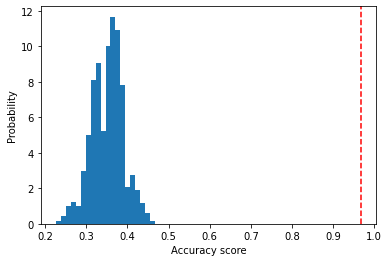

In [119]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(perm_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls='--', color='r')
score_label = (f"Score on original\ndata: {score_iris:.2f}\n"
               f"(p-value: {pvalue_iris:.3f})")
#ax.text(0.7, 260, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


- **random data**: plot the null distribution for the randomized data. The permutation scores are similar to those obtained using the original iris dataset because the permutation always destroys any feature label dependency present. The score obtained on the original randomized data in this case though, is very poor. This results in a large p-value, confirming that there was no feature label dependency in the original data.

Text(0, 0.5, 'Probability')

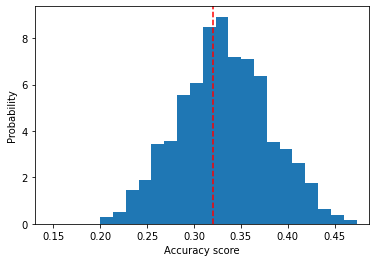

In [118]:
fig, ax = plt.subplots()

ax.hist(perm_scores_rand, bins=20, density=True)
ax.set_xlim(0.13)
ax.axvline(score_rand, ls='--', color='r')
score_label = (f"Score on original\ndata: {score_rand:.2f}\n"
               f"(p-value: {pvalue_rand:.3f})")
#ax.text(0.14, 125, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")

### [Helper Function: Cross-validation split visualizations](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)

In [62]:
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

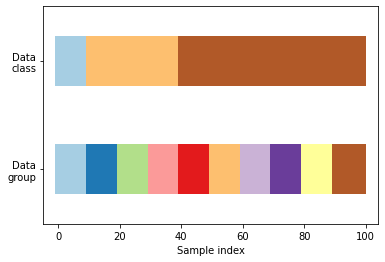

In [63]:
n_points = 100
X = np.random.randn(100, 10)
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
groups = np.hstack([[ii] * 10 for ii in range(10)])

def visualize_groups(classes, groups, name):
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)),  
               [.5] * len(groups), 
               c=groups, marker='_',
               lw=50, cmap=cmap_data)
    ax.scatter(range(len(groups)),  
               [3.5] * len(groups), 
               c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(ylim=[-1, 5], 
           yticks=[.5, 3.5],
           yticklabels=['Data\ngroup', 'Data\nclass'], 
           xlabel="Sample index")

visualize_groups(y, groups, 'no groups')


In [67]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):

    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        indices     = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    yticklabels = list(range(n_splits)) + ['class', 'group']
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 100])
    
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

ValueError: Found input variables with inconsistent numbers of samples: [8, 100, 100]

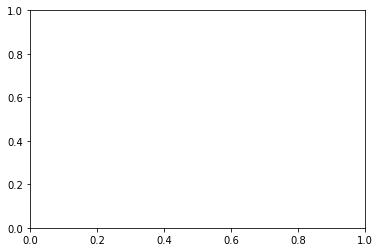

In [69]:
# k-fold
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

ValueError: Found input variables with inconsistent numbers of samples: [50, 50, 100]

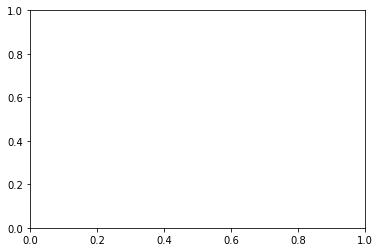

In [61]:
#stratified k-fold
fig, ax = plt.subplots()
cv = StratifiedKFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

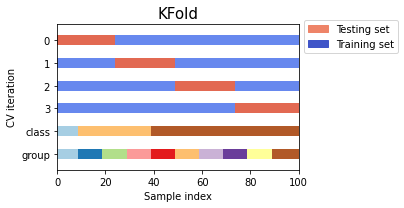

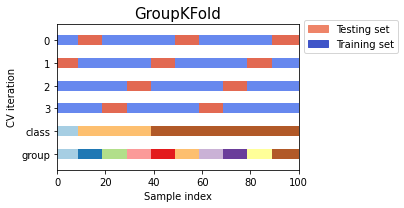

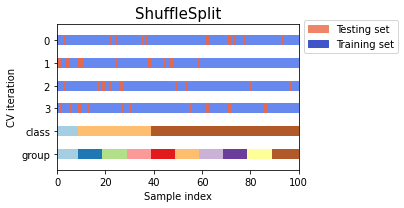

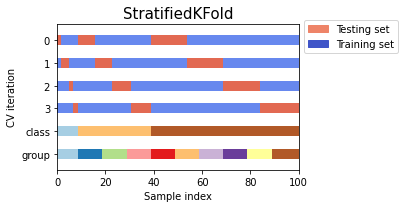

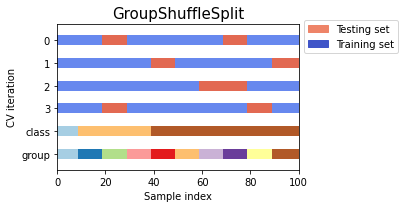

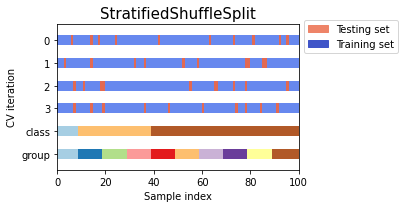

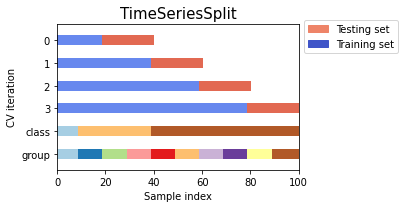

In [49]:
cvs = [KFold, GroupKFold, ShuffleSplit, StratifiedKFold,
       GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit]

for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=.7)

###

###

###

###

###